In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from roipoly import roipoly
import pylab as pl

In [2]:
# set data path
path_video = "/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/detectbuoy.avi"

# define constants
cap = cv2.VideoCapture(path_video)

# read video
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if(ret):
        # get current video frame
        # show the image
        pl.imshow(frame, interpolation='nearest', cmap="Greys")
        pl.colorbar()
        pl.title("left click: line segment         right click: close region")
        
        ROI1 = roipoly(roicolor='r')
        
        # show the image with the first ROI
        pl.imshow(frame, interpolation='nearest', cmap="Greys")
        pl.colorbar()
        ROI1.displayROI()
        pl.title('draw second ROI')
        break
    else:
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'pl' is not defined

In [25]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as mvn

/usr/lib/python2.7/dist-packages/scipy/stats/morestats.py:16: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import setastest


In [47]:
files = glob.glob("/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/*")
print(files)

['/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy65.png', '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy99.png', '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy64.png', '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy113.png', '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy103.png', '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy139.png', '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy39.png', '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy101.png', '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy67.png', '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy115.png', '/home/arpitdec5/Desktop/color_segmentation_using_gmm_and_em/data/buoy2/test/buoy38.png', '/ho

In [43]:
def plot_hist(image, value1, value2):
    # loop over the image channels
    chans = cv2.split(image)
    chan = chans[1]
    colors = "g"
    features = []
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    #hist = hist / hist.sum()
    features.extend(hist)
    plt.plot(hist, color = colors)
    #plt.plot(value1, color = "b")
    plt.xlim([0, 256])
    plt.ylim([0, 100])
    
    """
    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [], None, [256], [0, 256])
        hist = hist / hist.sum()
        features.extend(hist)
        plt.plot(hist, color = color)
        plt.xlim([0, 256])
    """

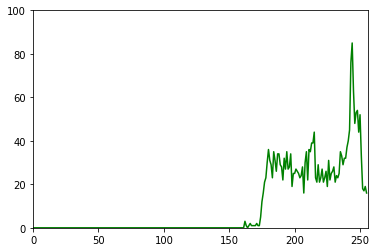

In [44]:
count = 0
for file in files:
    image = cv2.imread(files[12])
    plot_hist(image, value1, value2)
    count = count + 1
    
    if(count > 0):
        break

In [ ]:
# initialise step of em algorithm
def initialise(n, d, k):
    weights_gaussian = np.zeros(k)
    mean_gaussian = np.zeros(k, d)
    covariance_matrix_gaussian = np.zeros(k, d, d)
    probability_values = np.zeros(n, k)
    
    # randomly assign probability values
    for index in range(0, n):
        random_index = np.random.randint(0, k)
        probability_values[index][random_index] = 1

In [28]:
# gaussian estimation for expectation step
def gaussian_estimation(data_point, mean, covariance, dimension):
    """
    Inputs:
    data_point - data point of the gaussian, size (1 x d)
    mean - mean of the gaussian, size (1 x d)
    covariance - covariance of the gaussian, size (1 x d x d)
    dimension - dimension of the gaussian
    
    Outputs:
    value of the gaussian
    """
    
    determinant_covariance = np.linalg.det(covariance)
    determinant_covariance_root = np.sqrt(determinant_covariance)
    covariance_inverse = np.linalg.inv(covariance)
    gaussian_pi_coeff = 1.0 / np.power((2 * np.pi), (dimension / 2))
    data_mean_diff = (data_point - mean)
    data_mean_diff_transpose = data_mean_diff.T     
    return (gaussian_pi_coeff) * (determinant_covariance_root) * np.exp(-0.5 * np.matmul(np.matmul(data_mean_diff, covariance_inverse), data_mean_diff_transpose))

In [48]:
weights_gaussian = np.array([0.10965005, 0.89034995])
mean_gaussian = np.array([[213.99313937], [248.81861517]])
covariance_gaussian = np.array([[[834.021028]], [[ 32.14004098]]])

In [58]:
weights_gaussian = np.array([0.47356512, 0.50977045, 0.01666443])
mean_gaussian = np.array([[234.56041269], [234.75186891], [200.17510761]])
covariance_gaussian = np.array([[[ 38.79795013]], [[ 38.66358772]], [[663.63058132]]])

In [69]:
value1 = []
value2 = []
value3 = []
d = []
for value in range(0, 256):
    if(value % 2 == 0):
        d.append(1)
    else:
        d.append(0)
        
    for dimension in range(0, 3):
        value = gaussian_estimation(value, mean_gaussian[dimension], covariance_gaussian[dimension], 1) * weights_gaussian[dimension]
        if(dimension == 0):
            value1.append(value)
        elif(dimension == 1):
            value2.append(value)
        else:
            value3.append(value)

Text(0.5,1,'Fitted Gaussians(k = 2, d = 1) for Orange Buoy')

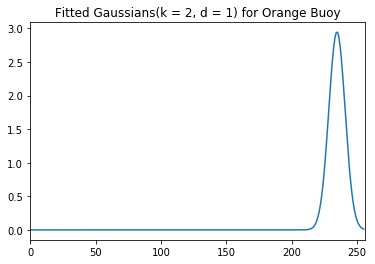

In [71]:
plt.plot(value1)
#plt.plot(value1)
#plt.plot(value3)
plt.xlim([0, 256])
plt.title("Fitted Gaussians(k = 2, d = 1) for Orange Buoy")